In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim    
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import numpy
from PIL import Image
from pylab import *
from skimage.feature import hog
from skimage import feature
from sklearn import datasets
import cv2
from skimage import exposure
import timeit
from skimage import transform as tf
from scipy import ndimage
from sklearn.decomposition import PCA
from scipy import fftpack

In [2]:
#Convolution Neural Network 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(20, 40, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 40, 500)
        self.fc2 = nn.Linear(500, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 4 * 4 * 40)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [3]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.99), eps=1e-08, weight_decay=0.001)  

In [4]:
# transforms to apply to the mnist data
# transforms to apply to the Fashion mnist data
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./fmnist/', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./fmnist/', train=False, download=True, transform=transform)
labels_map = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle Boot')

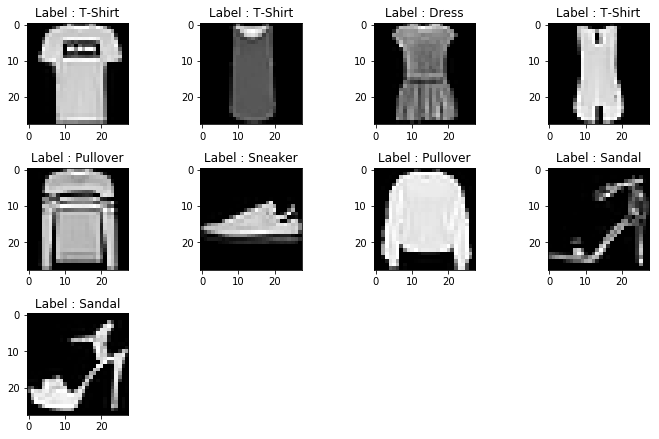

In [5]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_dataset.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %s' % labels_map[train_dataset.train_labels[i]])
plt.show()

In [6]:
#Spatial Processing of the Dataset
train_dataset.train_data = train_dataset.train_data.type(torch.FloatTensor)
test_dataset.test_data = test_dataset.test_data.type(torch.FloatTensor)
for i in range(0,len(train_dataset)):
    image = ndimage.binary_dilation(train_dataset.train_data[i].numpy()).astype(train_dataset.train_data[i].numpy().dtype)
    train_dataset.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_dataset)):
    image = ndimage.binary_dilation(test_dataset.test_data[i].numpy()).astype(test_dataset.test_data[i].numpy().dtype)
    test_dataset.test_data[i] = torch.from_numpy(image)

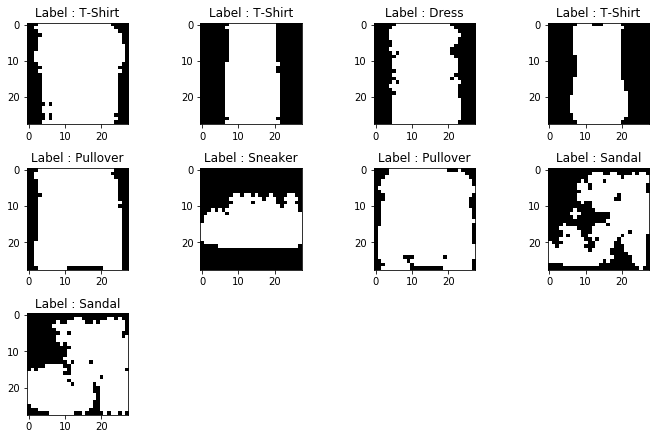

In [7]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_dataset.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %s' % labels_map[train_dataset.train_labels[i]])
plt.show()

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False, num_workers=2)

In [9]:
num_epochs = 20
total_step = len(train_loader)
Loss = []
print('----------------------------------------------------')
start= timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss.append(running_loss / total_step)
print('Finished Training')
stop = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.1229
----------------------------------------------------
Epoch 2  | Loss : 0.9844
----------------------------------------------------
Epoch 3  | Loss : 0.9392
----------------------------------------------------
Epoch 4  | Loss : 0.9165
----------------------------------------------------
Epoch 5  | Loss : 0.9022
----------------------------------------------------
Epoch 6  | Loss : 0.8942
----------------------------------------------------
Epoch 7  | Loss : 0.8857
----------------------------------------------------
Epoch 8  | Loss : 0.8810
----------------------------------------------------
Epoch 9  | Loss : 0.8770
----------------------------------------------------
Epoch 10  | Loss : 0.8723
----------------------------------------------------
Epoch 11  | Loss : 0.8692
----------------------------------------------------
Epoch 12  | Loss : 0.8693
----------------------------------------------------
Epoch 13

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 63 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
    labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 51 %
Accuracy of class Trouser : 87 %
Accuracy of class Pullover : 52 %
Accuracy of class Dress : 82 %
Accuracy of class Coat : 46 %
Accuracy of class Sandal : 22 %
Accuracy of class Shirt : 39 %
Accuracy of class Sneaker : 82 %
Accuracy of class Bag : 79 %
Accuracy of class Ankle Boot : 90 %


In [12]:
#Applying Different Feature extraction Methods
##SOBEL EDGE Detector##
train_sobel = train_dataset
test_sobel = test_dataset
for i in range(0,len(train_sobel)):
    image = ndimage.sobel(train_sobel.train_data[i].numpy()) 
    train_sobel.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_sobel)):
    image = ndimage.sobel(test_sobel.test_data[i].numpy()) 
    test_sobel.test_data[i] = torch.from_numpy(image)   

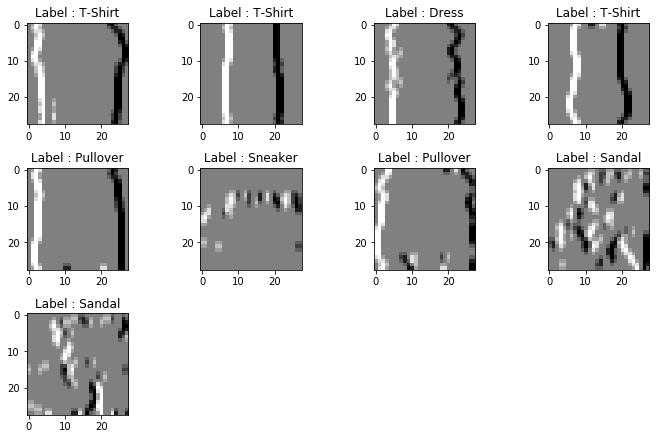

In [13]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_sobel.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %s' % labels_map[train_sobel.train_labels[i]])
plt.show()

In [14]:
train_sobel_loader = torch.utils.data.DataLoader(train_sobel, batch_size=10, shuffle=True, num_workers=2)
test_sobel_loader = torch.utils.data.DataLoader(dataset=test_sobel, batch_size=10, shuffle=False, num_workers=2)

In [15]:
num_epochs = 20
total_step = len(train_sobel_loader)
Loss_1 = []
print('----------------------------------------------------')
start1 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_sobel_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_1.append(running_loss / total_step)
print('Finished Training')
stop1 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.0273
----------------------------------------------------
Epoch 2  | Loss : 0.9154
----------------------------------------------------
Epoch 3  | Loss : 0.8879
----------------------------------------------------
Epoch 4  | Loss : 0.8710
----------------------------------------------------
Epoch 5  | Loss : 0.8612
----------------------------------------------------
Epoch 6  | Loss : 0.8538
----------------------------------------------------
Epoch 7  | Loss : 0.8470
----------------------------------------------------
Epoch 8  | Loss : 0.8447
----------------------------------------------------
Epoch 9  | Loss : 0.8395
----------------------------------------------------
Epoch 10  | Loss : 0.8343
----------------------------------------------------
Epoch 11  | Loss : 0.8322
----------------------------------------------------
Epoch 12  | Loss : 0.8289
----------------------------------------------------
Epoch 13

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_sobel_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 64 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_sobel_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 48 %
Accuracy of class Trouser : 86 %
Accuracy of class Pullover : 63 %
Accuracy of class Dress : 82 %
Accuracy of class Coat : 32 %
Accuracy of class Sandal : 37 %
Accuracy of class Shirt : 44 %
Accuracy of class Sneaker : 87 %
Accuracy of class Bag : 82 %
Accuracy of class Ankle Boot : 78 %


In [18]:
##CANNY EDGE DETECTOR##
train_canny  = train_dataset
test_canny = test_dataset

for i in range(0,len(train_canny)):
    image = feature.canny(train_canny.train_data[i].numpy()) * 1
    train_canny.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_canny)):
    image = feature.canny(test_canny.test_data[i].numpy()) * 1
    test_canny.test_data[i] = torch.from_numpy(image)

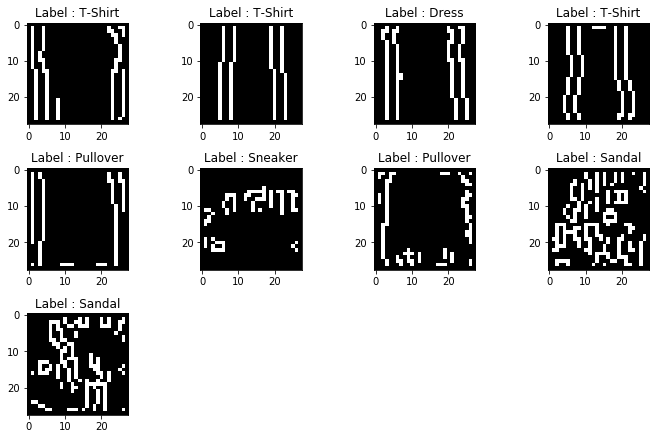

In [19]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_canny.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %s' % labels_map[train_canny.train_labels[i]])
plt.show()

In [20]:
train_canny_loader = torch.utils.data.DataLoader(train_canny, batch_size=10, shuffle=True, num_workers=2)
test_canny_loader = torch.utils.data.DataLoader(dataset=test_canny, batch_size=10, shuffle=False, num_workers=2)

In [21]:
num_epochs = 20
total_step = len(train_canny_loader)
Loss_2 = []
print('----------------------------------------------------')
start2 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_canny_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_2.append(running_loss / total_step)
print('Finished Training')
stop2 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.0618
----------------------------------------------------
Epoch 2  | Loss : 0.9801
----------------------------------------------------
Epoch 3  | Loss : 0.9594
----------------------------------------------------
Epoch 4  | Loss : 0.9476
----------------------------------------------------
Epoch 5  | Loss : 0.9388
----------------------------------------------------
Epoch 6  | Loss : 0.9334
----------------------------------------------------
Epoch 7  | Loss : 0.9306
----------------------------------------------------
Epoch 8  | Loss : 0.9270
----------------------------------------------------
Epoch 9  | Loss : 0.9234
----------------------------------------------------
Epoch 10  | Loss : 0.9192
----------------------------------------------------
Epoch 11  | Loss : 0.9181
----------------------------------------------------
Epoch 12  | Loss : 0.9157
----------------------------------------------------
Epoch 13

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_canny_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 61 %


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_canny_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 45 %
Accuracy of class Trouser : 85 %
Accuracy of class Pullover : 41 %
Accuracy of class Dress : 78 %
Accuracy of class Coat : 50 %
Accuracy of class Sandal : 49 %
Accuracy of class Shirt : 28 %
Accuracy of class Sneaker : 69 %
Accuracy of class Bag : 85 %
Accuracy of class Ankle Boot : 76 %


In [24]:
##LOCAL BINARY PATTERN##
train_lbp = train_dataset
test_lbp = test_dataset

for i in range(0,len(train_lbp)):
    image = feature.local_binary_pattern(train_lbp.train_data[i].numpy(), P = 100, R = 50)
    train_lbp.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_lbp)):
    image = feature.local_binary_pattern(test_lbp.test_data[i].numpy(), P = 100, R = 50)
    test_lbp.test_data[i] = torch.from_numpy(image)

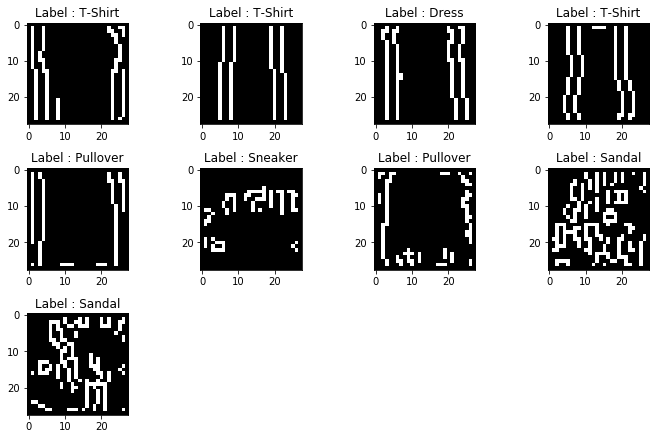

In [25]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_lbp.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %s' % labels_map[train_lbp.train_labels[i]])
plt.show()

In [26]:
train_lbp_loader = torch.utils.data.DataLoader(train_lbp, batch_size=10, shuffle=True, num_workers=2)
test_lbp_loader = torch.utils.data.DataLoader(dataset=test_lbp, batch_size=10, shuffle=False, num_workers=2)

In [27]:
num_epochs = 20
total_step = len(train_lbp_loader)
Loss_3 = []
print('----------------------------------------------------')
start3 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_lbp_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_3.append(running_loss / total_step)
print('Finished Training')
stop3 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.2039
----------------------------------------------------
Epoch 2  | Loss : 1.0333
----------------------------------------------------
Epoch 3  | Loss : 1.0004
----------------------------------------------------
Epoch 4  | Loss : 0.9846
----------------------------------------------------
Epoch 5  | Loss : 0.9736
----------------------------------------------------
Epoch 6  | Loss : 0.9665
----------------------------------------------------
Epoch 7  | Loss : 0.9602
----------------------------------------------------
Epoch 8  | Loss : 0.9562
----------------------------------------------------
Epoch 9  | Loss : 0.9509
----------------------------------------------------
Epoch 10  | Loss : 0.9483
----------------------------------------------------
Epoch 11  | Loss : 0.9458
----------------------------------------------------
Epoch 12  | Loss : 0.9435
----------------------------------------------------
Epoch 13

In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_lbp_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 59 %


In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_lbp_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 50 %
Accuracy of class Trouser : 85 %
Accuracy of class Pullover : 33 %
Accuracy of class Dress : 73 %
Accuracy of class Coat : 59 %
Accuracy of class Sandal : 53 %
Accuracy of class Shirt : 24 %
Accuracy of class Sneaker : 76 %
Accuracy of class Bag : 84 %
Accuracy of class Ankle Boot : 54 %


In [30]:
##PEAK LOCAL MAXIMA##
train_plm = train_dataset
test_plm = test_dataset

for i in range(0,len(train_plm)):
    image = feature.peak_local_max(train_plm.train_data[i].numpy(), indices = False) * 1
    train_plm.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_plm)):
    image = feature.peak_local_max(test_plm.test_data[i].numpy(), indices = False) * 1
    test_plm.test_data[i] = torch.from_numpy(image)

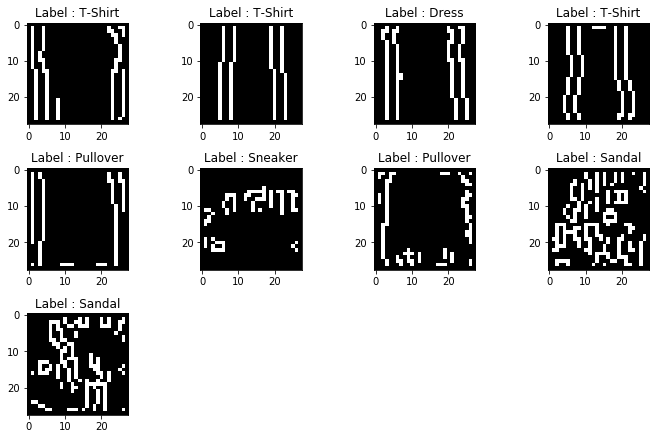

In [31]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_plm.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %s' % labels_map[train_plm.train_labels[i]])
plt.show()

In [32]:
train_plm_loader = torch.utils.data.DataLoader(train_plm, batch_size=10, shuffle=True, num_workers=2)
test_plm_loader = torch.utils.data.DataLoader(dataset=test_plm, batch_size=10, shuffle=False, num_workers=2)

In [33]:
num_epochs = 20
total_step = len(train_plm_loader)
Loss_4 = []
print('----------------------------------------------------')
start4 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_plm_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_4.append(running_loss / total_step)
print('Finished Training')
stop4 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.0526
----------------------------------------------------
Epoch 2  | Loss : 0.9691
----------------------------------------------------
Epoch 3  | Loss : 0.9527
----------------------------------------------------
Epoch 4  | Loss : 0.9456
----------------------------------------------------
Epoch 5  | Loss : 0.9396
----------------------------------------------------
Epoch 6  | Loss : 0.9355
----------------------------------------------------
Epoch 7  | Loss : 0.9337
----------------------------------------------------
Epoch 8  | Loss : 0.9296
----------------------------------------------------
Epoch 9  | Loss : 0.9284
----------------------------------------------------
Epoch 10  | Loss : 0.9272
----------------------------------------------------
Epoch 11  | Loss : 0.9244
----------------------------------------------------
Epoch 12  | Loss : 0.9229
----------------------------------------------------
Epoch 13

In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_plm_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 59 %


In [35]:
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_plm_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 40 %
Accuracy of class Trouser : 88 %
Accuracy of class Pullover : 50 %
Accuracy of class Dress : 72 %
Accuracy of class Coat : 41 %
Accuracy of class Sandal : 38 %
Accuracy of class Shirt : 39 %
Accuracy of class Sneaker : 65 %
Accuracy of class Bag : 77 %
Accuracy of class Ankle Boot : 84 %


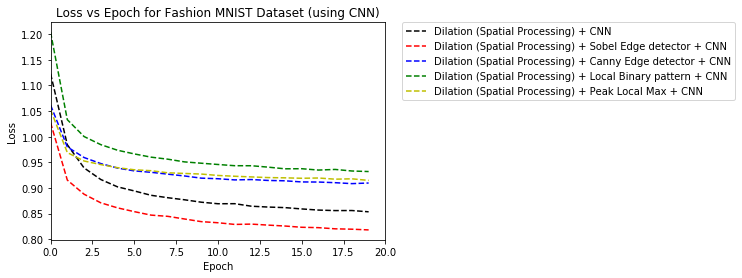

In [36]:
plt.plot(Loss, 'k--', label = "Dilation (Spatial Processing) + CNN")
plt.plot(Loss_1, 'r--', label = "Dilation (Spatial Processing) + Sobel Edge detector + CNN")
plt.plot(Loss_2, 'b--', label = "Dilation (Spatial Processing) + Canny Edge detector + CNN")
plt.plot(Loss_3, 'g--', label = "Dilation (Spatial Processing) + Local Binary pattern + CNN")
plt.plot(Loss_4, 'y--', label = "Dilation (Spatial Processing) + Peak Local Max + CNN")
plt.title("Loss vs Epoch for Fashion MNIST Dataset (using CNN)")
plt.xlim([0, num_epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [37]:
print("Computation time for classifying the data for Dilation (Spatial Processing) + CNN : %f minutes" %((stop-start)/60))
print("Computation time for classifying the data for Dilation (Spatial Processing) + Sobel Edge detector + CNN : %f minutes" %((stop1-start1)/60))
print("Computation time for classifying the data for Dilation (Spatial Processing) + Canny Edge detector + CNN : %f minutes" %((stop2-start2)/60))
print("Computation time for classifying the data for Dilation (Spatial Processing) + Local Binary pattern + CNN : %f minutes" %((stop3-start3)/60))
print("Computation time for classifying the data for Dilation (Spatial Processing) + Peak Local Max + CNN : %f minutes" %((stop4-start4)/60))

Computation time for classifying the data for Dilation (Spatial Processing) + CNN : 15.259150 minutes
Computation time for classifying the data for Dilation (Spatial Processing) + Sobel Edge detector + CNN : 14.643653 minutes
Computation time for classifying the data for Dilation (Spatial Processing) + Canny Edge detector + CNN : 15.706311 minutes
Computation time for classifying the data for Dilation (Spatial Processing) + Local Binary pattern + CNN : 16.936730 minutes
Computation time for classifying the data for Dilation (Spatial Processing) + Peak Local Max + CNN : 16.393105 minutes
